# Fashion MNIST Custom Training Loop

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [2]:
DATA_DIR = "/Users/shankar/dev/data/competitions/tfds/fashion_mnist"
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir=DATA_DIR, download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir=DATA_DIR, download=True)

Shuffling and writing examples to /Users/shankar/dev/data/competitions/tfds/fashion_mnist/fashion_mnist/3.0.1.incompleteWTQSMZ/fashion_mnist-train.tfrecord


Shuffling and writing examples to /Users/shankar/dev/data/competitions/tfds/fashion_mnist/fashion_mnist/3.0.1.incompleteWTQSMZ/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /Users/shankar/dev/data/competitions/tfds/fashion_mnist/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
def format_image(data):
    image = data['image']
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [5]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [6]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size=batch_size)

## Define the Model

In [8]:
def base_model():
    inputs = tf.keras.Input(shape=(784,), name='digits')
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax", name="predictions")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [10]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building the Training Loop

In [11]:
def apply_gradient(optimixer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return logits, loss_value

In [12]:
def train_data_for_one_epoch():
    losses = []
    pbar = tqdm(
        total=len(list(enumerate(train))),
        position=0,
        leave=True,
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} '
    )
    
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        logits, loss_value = apply_gradient(
            optimizer, 
            model,
            x_batch_train,
            y_batch_train
        )
        losses.append(loss_value)
        
        train_acc_metric(y_batch_train, logits)
        pbar.set_description(f"Training loss for step {int(step)}: {round(float(loss_value), 4)}")
        pbar.update()
    return losses

In [13]:
def perform_validation():
    losses = []
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

In [14]:
model = base_model()

epochs = 10
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print(f'Start of epoch {epoch}')
    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()
    
    losses_val = perform_validation()
    val_acc = val_acc_metric.result()
    
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)
    
    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (
        epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)
    ))
    
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.4018: 100%|█████████▉| 937/938 


 Epoch 0: Train loss: 0.5365  Validation Loss: 0.4463, Train Accuracy: 0.8122, Validation Accuracy 0.8407
Start of epoch 1


Training loss for step 937: 0.6521: 100%|█████████▉| 937/938 


 Epoch 1: Train loss: 0.3897  Validation Loss: 0.4002, Train Accuracy: 0.8598, Validation Accuracy 0.8583
Start of epoch 2


Training loss for step 937: 0.3458: 100%|█████████▉| 937/938 


 Epoch 2: Train loss: 0.3501  Validation Loss: 0.4051, Train Accuracy: 0.8734, Validation Accuracy 0.8580
Start of epoch 3


Training loss for step 937: 0.6408: 100%|█████████▉| 937/938 


 Epoch 3: Train loss: 0.3285  Validation Loss: 0.3933, Train Accuracy: 0.8804, Validation Accuracy 0.8577
Start of epoch 4


Training loss for step 937: 0.4892: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.3140  Validation Loss: 0.3659, Train Accuracy: 0.8838, Validation Accuracy 0.8708
Start of epoch 5


Training loss for step 937: 0.1992: 100%|█████████▉| 937/938 


 Epoch 5: Train loss: 0.2980  Validation Loss: 0.3608, Train Accuracy: 0.8896, Validation Accuracy 0.8742
Start of epoch 6


Training loss for step 937: 0.1958: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2875  Validation Loss: 0.3599, Train Accuracy: 0.8937, Validation Accuracy 0.8748
Start of epoch 7


Training loss for step 937: 0.1147: 100%|█████████▉| 937/938 


 Epoch 7: Train loss: 0.2761  Validation Loss: 0.3570, Train Accuracy: 0.8974, Validation Accuracy 0.8749
Start of epoch 8


Training loss for step 937: 0.1323: 100%|█████████▉| 937/938 


 Epoch 8: Train loss: 0.2641  Validation Loss: 0.3511, Train Accuracy: 0.9019, Validation Accuracy 0.8786
Start of epoch 9


Training loss for step 937: 0.1453: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.2595  Validation Loss: 0.3581, Train Accuracy: 0.9028, Validation Accuracy 0.8736


## Evaluate Model

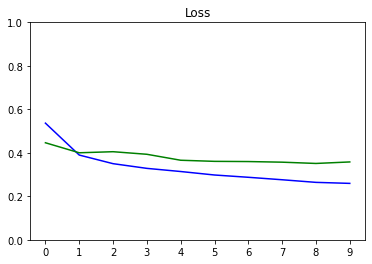

In [15]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric, color='blue', label=metric_name)
    plt.plot(val_metric, color='green', label='val_'+metric_name)
    
plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [16]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], display_strings)
    plt.grid(None)
    image = np.reshape(image, [n, 28, 28])
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [28, 28*n])
    plt.imshow(image)

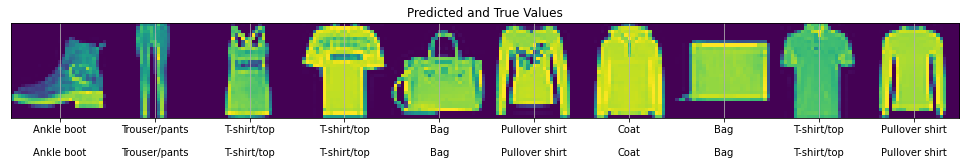

In [17]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []


for x, y in test_inputs:
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_true_batches = y.numpy()
    x_batches = x.numpy()
    
indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)    